In [1]:
import os
os.chdir('../')

In [2]:
import torch
import numpy as np

noises = []
datas = []
classes = []
for i in range(100):
    file = f'samples/256x256_diffusion/unipc_200_scale2.0/images/samples_{i}.npz'
    if not os.path.exists(file):
        break
    data = np.load(file)
    noises.append(data['noises_raw'])
    datas.append(data['datas_raw'])
    classes.append(data['classes'])

noises = torch.tensor(np.concatenate(noises, axis=0))
datas = torch.tensor(np.concatenate(datas, axis=0))
classes = torch.tensor(np.concatenate(classes, axis=0))
print(noises.shape, datas.shape, classes.shape)

torch.Size([240, 3, 256, 256]) torch.Size([240, 3, 256, 256]) torch.Size([240])


In [ ]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import random

from sample import parse_args_and_config, Diffusion
from runners.diffusion import inverse_data_transform

# seed = 42
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# torch.backends.cudnn.deterministic = True
# torch.backends.benchmark = False

###############################################################################
# 1) Notebook에서 sys.argv를 직접 설정 (argparse 흉내)
###############################################################################
sys.argv = [
    "sample.py",
    "--config", "imagenet256_guided.yml",  # 사용하려는 config
    "--sample_type", "rbf_ecp_marginal",
    "--timesteps", "20",
    "--scale", "2.0",
    "--order", "3",
    "--lower_order_final",
    "--scale_dir", "/data/guided-diffusion/scale/rbf_ecp_marginal2.0"
]
###############################################################################
# 2) 인자/설정 로드
###############################################################################
args, config = parse_args_and_config()

###############################################################################
# 3) Diffusion 객체 생성 -> 모델 로딩
###############################################################################
diffusion = Diffusion(args, config, rank=0)
diffusion.prepare_model()


INFO - sample.py - 2025-04-13 12:02:00,865 - Using device: cuda


[prepare_model] Model is ready.


[ 78 107  55 179 237 101 205  90 176  66  87  64 137  73 207 188]
def sample_by_target_matching start!!!
x.shape: torch.Size([16, 3, 256, 256]), target.shape: torch.Size([16, 3, 256, 256]), steps: 20, order: 2, skip_type: time_uniform, lower_order_final: True
/data/guided-diffusion/scale/rbf_ecp_marginal2.0/NFE=20,p=2,number=0.npz  saved!
tensor(0.0018, device='cuda:0')


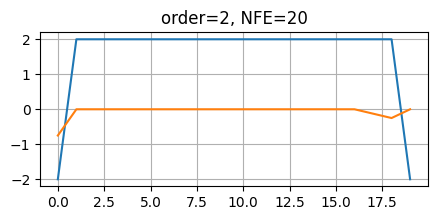

In [4]:
import torch.nn.functional as F

for number in range(1):
    indexes = np.random.randint(0, len(noises), size=(16,))
    print(indexes)
    noise_batch = noises[indexes].to(device=diffusion.device)
    target_batch = datas[indexes].to(device=diffusion.device)
    classes_batch = classes[indexes].to(device=diffusion.device)
    with torch.no_grad():
        sampled_x, _ = diffusion.sample_image(noise_batch, diffusion.model, classifier=diffusion.classifier, classes=classes_batch, target=target_batch, number=number)
        print(F.mse_loss(target_batch, sampled_x))

        data = np.load(f'/data/guided-diffusion/scale/rbf_ecp_marginal{args.scale}/NFE={args.timesteps},p={args.order},number={number}.npz')

        import matplotlib.pyplot as plt
        plt.figure(figsize=[5, 2])
        plt.title(f'order={args.order}, NFE={args.timesteps}')
        plt.plot(data['optimal_log_scales'].T)
        plt.grid()
        plt.show()



['optimal_log_scales', 'loss_grid_list']


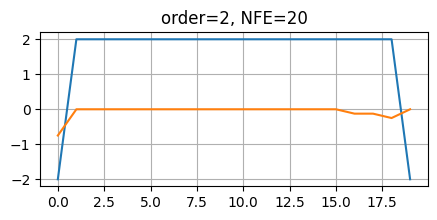

In [5]:
data = np.load(f'/data/guided-diffusion/scale/rbf_ecp/NFE={args.timesteps},p={args.order}.npz')
print(list(data.keys()))

import matplotlib.pyplot as plt
plt.figure(figsize=[5, 2])
plt.title(f'order={args.order}, NFE={args.timesteps}')
plt.plot(data['optimal_log_scales'].T)
plt.grid()
plt.show()

In [6]:
args.order

2